## Import Libraries

In [1]:
import tensorflow as tf
import keras 
from keras.layers import Dense, Conv2D, MaxPool2D, UpSampling2D, Dropout, Input
from keras.preprocessing.image import img_to_array
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm 
import numpy as np
import os
import re
from skimage.measure import compare_ssim
from scipy import ndimage
import random

## Load data
Here I am going to load only 2500 images each with mask and no mask. These images are converted to an array and are appended in empty array. Here I also have defind function to load data serially. 

In [2]:
# to get the files in proper order
def sorted_alphanumeric(data):  
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)',key)]
    return sorted(data,key = alphanum_key)


# defining the size of image 
SIZE = 256

mask_path = '../input/face-mask-lite-dataset/with_mask'
mask_array = []

image_path = '../input/face-mask-lite-dataset/without_mask'
img_array = []

image_file = sorted_alphanumeric(os.listdir(image_path))
mask_file = sorted_alphanumeric(os.listdir(mask_path))

        
for i in tqdm(image_file):
 
    if i == 'seed1500.png':
        break
    
    else:
        image = cv2.imread(image_path + '/' + i,1)

        # as opencv load image in bgr format converting it to rgb
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # resizing images 
        image = cv2.resize(image, (SIZE, SIZE))

        # normalizing image 
        image = image.astype('float32') / 255.0
        # appending normal sketch image
        img_array.append(img_to_array(image))

 15%|█▌        | 1500/10000 [01:34<08:57, 15.82it/s]


In [3]:
for i in tqdm(mask_file):
    if i == 'with-mask-default-mask-seed1500.png':
        break
    else:    
        image = cv2.imread(mask_path + '/' + i,1)

          # as opencv load image in bgr format converting it to rgb
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # resizing images 
        image = cv2.resize(image, (SIZE, SIZE))

        # normalizing image 
        image = image.astype('float32') / 255.0

        #appending normal normal image    
        mask_array.append(img_to_array(image))

 15%|█▌        | 1500/10000 [01:33<08:52, 15.97it/s]


In [4]:
train_mask_image = mask_array[:1450]
train_image = img_array[:1450]
test_mask_image = mask_array[1450:]
test_image = img_array[1450:]
# reshaping
train_mask_image = np.reshape(train_mask_image,(len(train_mask_image),SIZE,SIZE,3))
train_image = np.reshape(train_image, (len(train_image),SIZE,SIZE,3))
print('Train no mask image shape:',train_image.shape)
test_mask_image = np.reshape(test_mask_image,(len(test_mask_image),SIZE,SIZE,3))
test_image = np.reshape(test_image, (len(test_image),SIZE,SIZE,3))
print('Test no mask image shape',test_image.shape)

Train no mask image shape: (1450, 256, 256, 3)
Test no mask image shape (50, 256, 256, 3)


In [5]:
def plot_image_pair(images = 5):
    for i in range(images):
        plt.figure(figsize = (7,7))
        plt.subplot(1,3,1)
        plt.title("No Mask", fontsize = 15)
        plt.imshow(img_array[i].reshape(SIZE, SIZE, 3))
        plt.subplot(1,3,2)
        plt.title("Mask", fontsize = 15)
        plt.imshow(mask_array[i].reshape(SIZE, SIZE, 3))
        plt.subplot(1,3,3)
        plt.title("Mask", fontsize = 15)
        plt.imshow(mask_array_edit[i].reshape(SIZE, SIZE, 3))
        

100%|██████████| 1450/1450 [00:05<00:00, 255.05it/s]


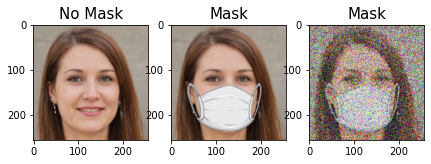

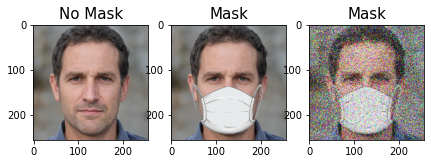

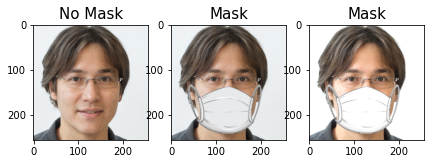

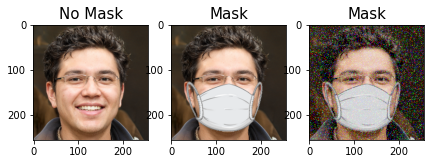

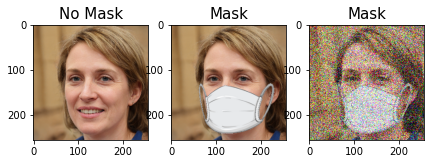

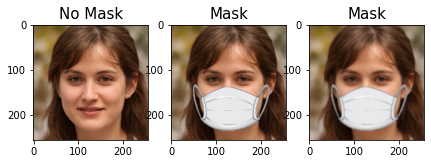

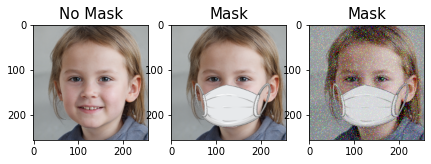

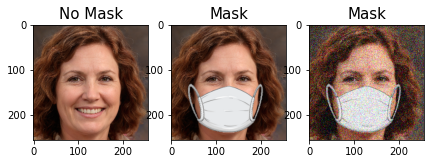

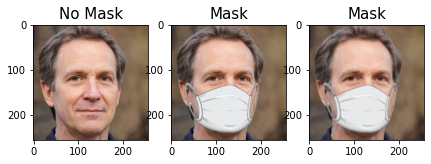

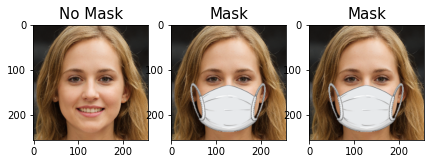

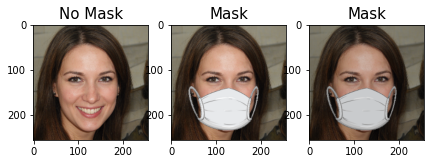

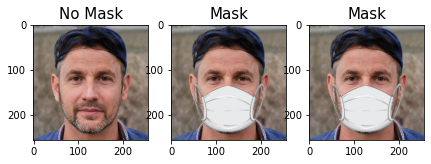

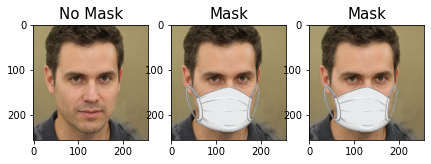

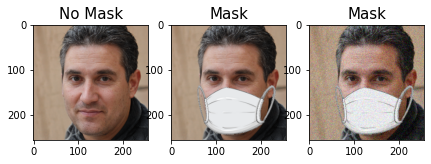

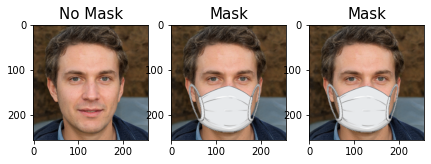

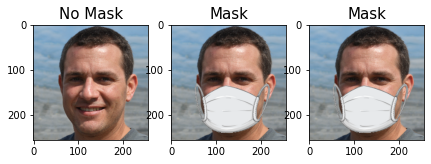

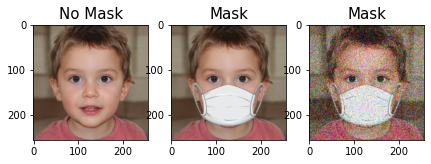

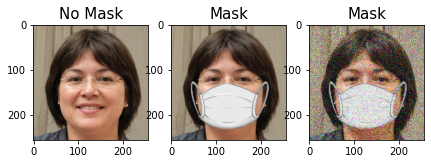

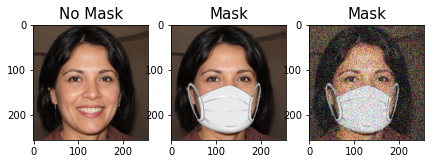

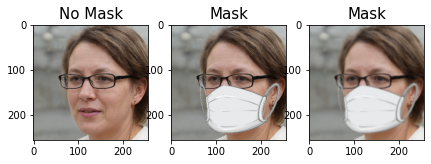

In [6]:
def blurImage(im):
    k = random.randint(1,3)
    k = k * 2 + 1
    res = cv2.GaussianBlur(im,(k,k),0)
    return res

def medFilt(im):
    res = np.uint8(im*256)
    res = cv2.medianBlur(res,5)
    return res

def rotImage(im):   
    #rotation angle in degree
    (h, w) = im.shape[:2]
    (cX, cY) = (w // 2, h // 2)
    deg = random.random() - 0.5
    isflip = random.random()
    M = cv2.getRotationMatrix2D((cX, cY), 20*deg, 1.0)
    res = cv2.warpAffine(im, M, (w, h))
    
    if isflip>0.5:
        res = flipImage(res)
    return res

def flipImage(im):
    res = np.fliplr(im)
    return res

def saltPImage(im):
    (h, w) = image.shape[:2]
    sc = random.random()
    m = np.random.normal(scale=sc/2,size = (h,w,3))
    res = im + m
    return res

def shotNoise(im):
    (h, w) = image.shape[:2]
    rng = np.random.default_rng()
    sc = random.random() / 10
    s = rng.poisson(sc, (h,w,3)) - sc
    res = im + s
    return res

def darkenIm(im):
    factor = random.random()
    res = im * (0.7+factor/2)
    return res

def brightenIm(im):
    factor = random.random()
    factor = factor / 2 + 0.5
    res = im / factor
    return res

def changeColour(im):
    order = np.random.permutation(range(3))
    res = im[:,:,[order[0], order[1], order[2]]]
    return res

mask_array_edit = train_mask_image.copy()
for iter in range(3):
    for ind in tqdm(range(len(train_mask_image))):
        im = train_mask_image[ind]
        alg = random.random()
        if alg < 0.05:
            res = im
        elif alg < 0.2 and alg > 0.05:
            res = blurImage(im)
      #  elif alg < 0.3 and alg > 0.2:
      #      res = medFilt(im)
        elif alg < 0.3 and alg > 0.2:
            res = im
        elif alg < 0.35 and alg > 0.3:
            res = rotImage(im)
        elif alg < 0.55 and alg > 0.35:
            res = saltPImage(im)
        elif alg < 0.65 and alg > 0.55:
            res = changeColour(im)
        elif alg < 0.7 and alg > 0.65:
            res = darkenIm(im)
        elif alg < 0.8 and alg > 0.7:
            res = shotNoise(im)
        elif alg < 0.9 and alg > 0.8:
            res = shotNoise(im)
            # res = brightenIm(im)
        else:
            res = saltPImage(im)
        mask_array_edit[ind] = res
    
plot_image_pair(20)

## Defining our model

In [7]:
#"Encoding"
input_photo = keras.Input(shape=(256,256, 3), name="img")
x = Conv2D(filters = 16, kernel_size = (3,3), activation = 'relu', padding = 'same')(input_photo)
x = MaxPool2D(pool_size = (2,2))(x)

x = Conv2D(filters = 32,kernel_size = (3,3),strides = (2,2), activation = 'relu', padding = 'valid')(x)
x = Conv2D(filters = 64, kernel_size = (3,3), strides = (2,2), activation = 'relu', padding = 'same')(x)
x = MaxPool2D(pool_size = (2,2))(x)

x = Conv2D(filters = 128, kernel_size = (3,3), activation = 'relu', padding = 'same')(x)
x = Conv2D(filters = 256 , kernel_size = (3,3), activation = 'relu', padding = 'same')(x)

encoder_output = Conv2D(filters = 512 , kernel_size = (3,3), activation = 'relu', padding = 'same')(x) 

#"Decoding/Upsampling"
upsampling_input = Conv2D(filters = 512 ,kernel_size = (3,3), activation = 'relu', padding = 'same')(encoder_output)
x = UpSampling2D(size = (2,2))(upsampling_input)
x = Conv2D(filters = 256, kernel_size = (3,3), activation = 'relu', padding = 'same')(x)
x = Conv2D(filters = 128, kernel_size = (3,3), activation = 'relu', padding = 'same')(x)
x = Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu', padding = 'same')(x)

x = UpSampling2D(size = (2,2) )(x)

x = UpSampling2D(size = (2,2) )(x)
x = Conv2D(filters = 32 , kernel_size = (3,3), activation = 'relu', padding = 'same')(x)
x = UpSampling2D(size = (2,2) )(x)
 
x = Conv2D(filters = 16  , kernel_size = (3,3), activation = 'relu', padding = 'same')(x)
output_photo = Conv2D(filters = 3, kernel_size = (3,3), activation = 'relu', padding = 'same')(x)

# final model
model = keras.Model(input_photo, output_photo)
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img (InputLayer)             [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 63, 63, 32)        4640      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 128)      

## Compiling our model

In [8]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), loss = 'mean_absolute_error',
              metrics =['acc'])


model.fit(mask_array_edit, train_image, epochs = 45)

Epoch 1/45
46/46 [==============================] - 5s 118ms/step - loss: 0.4134 - acc: 0.0720
Epoch 2/45
46/46 [==============================] - 5s 109ms/step - loss: 0.2475 - acc: 0.0648
Epoch 3/45
46/46 [==============================] - 5s 106ms/step - loss: 0.1555 - acc: 0.4775
Epoch 4/45
46/46 [==============================] - 5s 107ms/step - loss: 0.0860 - acc: 0.8582
Epoch 5/45
46/46 [==============================] - 5s 107ms/step - loss: 0.0798 - acc: 0.8582
Epoch 6/45
46/46 [==============================] - 5s 109ms/step - loss: 0.0742 - acc: 0.8459
Epoch 7/45
46/46 [==============================] - 5s 106ms/step - loss: 0.0697 - acc: 0.8491
Epoch 8/45
46/46 [==============================] - 5s 107ms/step - loss: 0.0664 - acc: 0.8497
Epoch 9/45
46/46 [==============================] - 5s 106ms/step - loss: 0.0635 - acc: 0.8473
Epoch 10/45
46/46 [==============================] - 5s 105ms/step - loss: 0.0622 - acc: 0.8506
Epoch 11/45
46/46 [==============================

## Model evaluation

In [9]:
loss_acc= model.evaluate(test_mask_image, test_image)
print("Loss: ",loss_acc[0])
print('Accuracy: ', np.round(loss_acc[1],2) * 100)

2/2 [==============================] - 0s 148ms/step - loss: 0.0434 - acc: 0.9035
Loss:  0.04336503893136978
Accuracy:  90.0


## plotting images

In [10]:
def plot_images(start = 0, end = 5):
    for i in range(start, end, 1):
        plt.figure(figsize = (10,10))
        plt.subplot(1,3,1)
        plt.title("No Mask", fontsize = 12)
        plt.imshow(test_image[i])
        plt.subplot(1,3,2)
        plt.title("Mask", fontsize = 12)
        plt.imshow(test_mask_image[i])
        plt.subplot(1,3,3)
        plt.title("Predicted", fontsize = 12)
        prediction = model.predict(test_mask_image[i].reshape(1,SIZE, SIZE, 3)).reshape(SIZE, SIZE, 3)
        plt.imshow(prediction)
        plt.show()
        

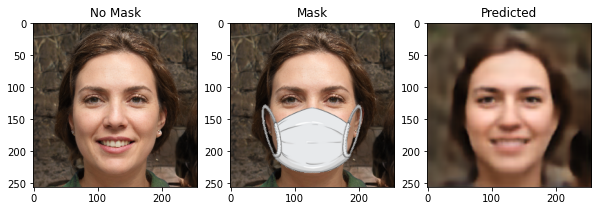

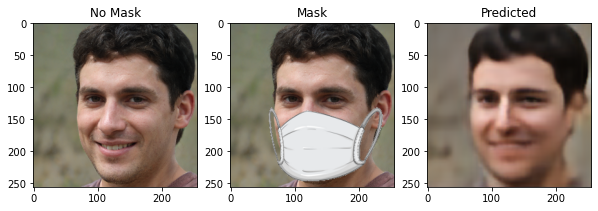

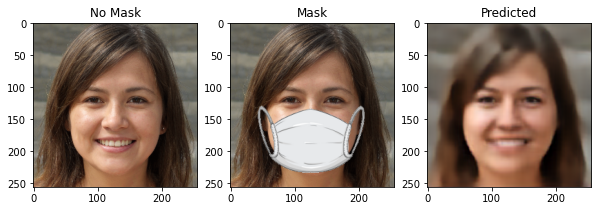

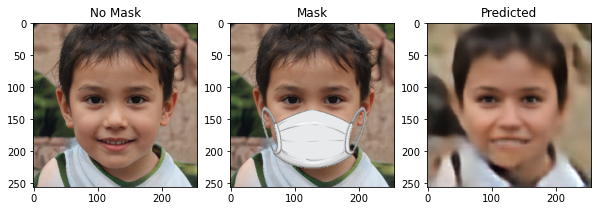

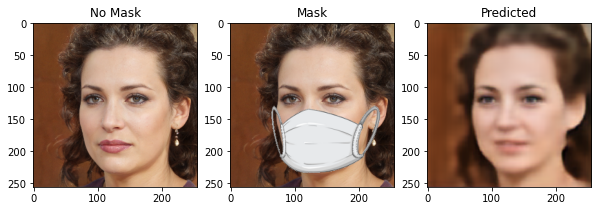

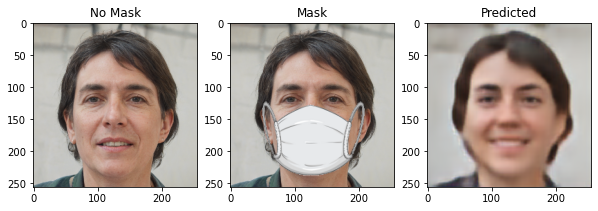

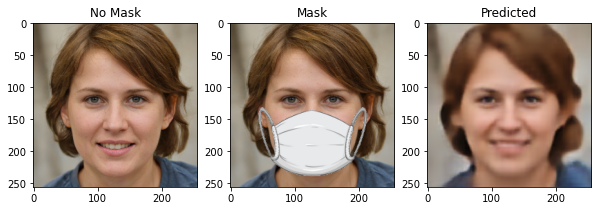

In [11]:
plot_images(5,12)

In [12]:


mask_path = '../input/test33/'
mask_array = []


mask_file = sorted_alphanumeric(os.listdir(mask_path))
for i in tqdm(mask_file):
    image = cv2.imread(mask_path + '/' + i,1)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (SIZE, SIZE))
    image = image.astype('float32') / 255.0
    mask_array.append(img_to_array(image))
    



100%|██████████| 8/8 [00:00<00:00, 43.26it/s]


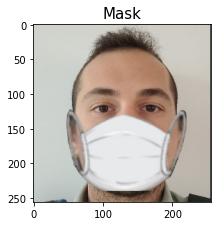

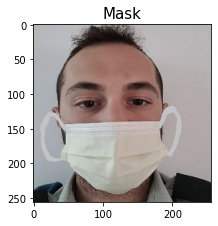

In [13]:
def plot_image_pair(images = 1):
    for i in range(images):
        plt.figure(figsize = (7,7))
        plt.subplot(1,2,1)
        plt.title("Mask", fontsize = 15)
        plt.imshow(mask_array[i].reshape(SIZE, SIZE, 3))

        
        
        
plot_image_pair(2)

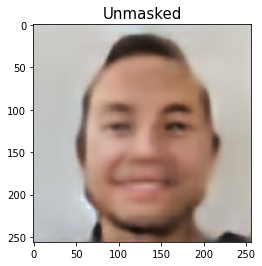

In [14]:
prediction = model.predict(mask_array[0].reshape(1,SIZE, SIZE, 3)).reshape(SIZE, SIZE, 3)
plt.title("Unmasked", fontsize = 15)
plt.imshow(prediction)

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imshow, imread
from skimage.color import rgb2yuv, rgb2hsv, rgb2gray, yuv2rgb, hsv2rgb
from scipy.signal import convolve2d

In [16]:
sharpen = np.array([[0, -1, 0],
                    [-1, 5, -1],
                    [0, -1, 0]])

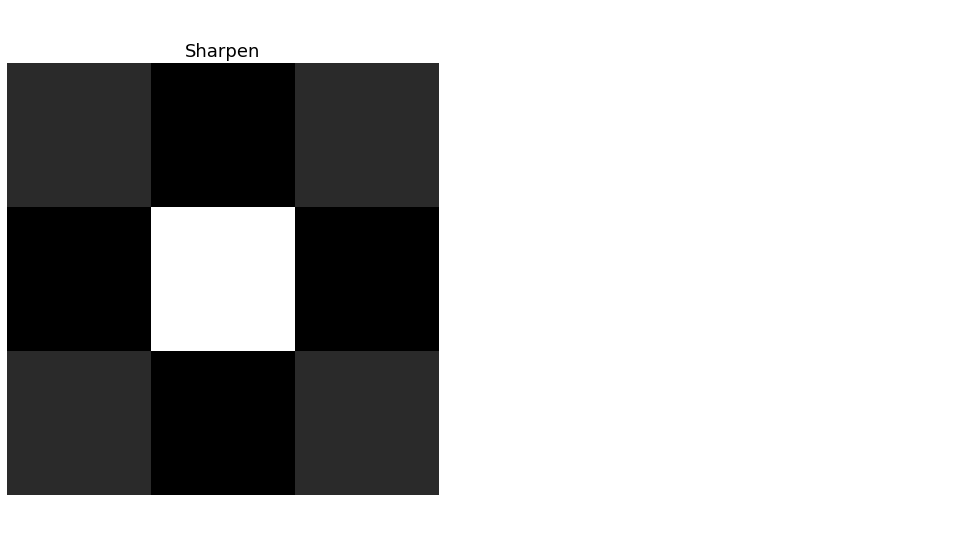

In [17]:
fig, ax = plt.subplots(1,2, figsize = (17,10))
ax[0].imshow(sharpen, cmap='gray')
ax[0].set_title(f'Sharpen', fontsize = 18)

    
[axi.set_axis_off() for axi in ax.ravel()];

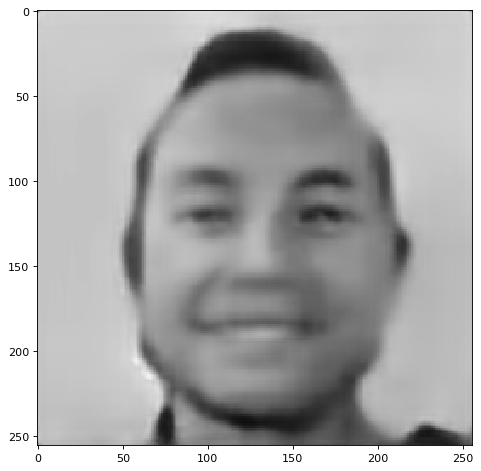

In [18]:
dog_grey = rgb2gray(prediction)
plt.figure(num=None, figsize=(8, 6), dpi=80)
imshow(dog_grey);

In [19]:
def multi_convolver(image, kernel, iterations):
    for i in range(iterations):
        image = convolve2d(image, kernel, 'same', boundary = 'fill',
                           fillvalue = 0)
    return image

In [20]:
def convolver_rgb(image, kernel, iterations = 1):
    convolved_image_r = multi_convolver(image[:,:,0], kernel,
                                        iterations)
    convolved_image_g = multi_convolver(image[:,:,1], kernel, 
                                        iterations)
    convolved_image_b  = multi_convolver(image[:,:,2], kernel, 
                                         iterations)
    
    reformed_image = np.dstack((np.rint(abs(convolved_image_r)), 
                                np.rint(abs(convolved_image_g)), 
                                np.rint(abs(convolved_image_b)))) /  255
   
                               
                     
    fig, ax = plt.subplots(1,3, figsize = (17,10))
    
    ax[0].imshow(abs(convolved_image_r), cmap='Reds')
    ax[0].set_title(f'Red', fontsize = 15)
    
    ax[1].imshow(abs(convolved_image_g), cmap='Greens')
    ax[1].set_title(f'Green', fontsize = 15)
    
    ax[2].imshow(abs(convolved_image_b), cmap='Blues')
    ax[2].set_title(f'Blue', fontsize = 15)
    
    [axi.set_axis_off() for axi in ax.ravel()]
    
    return np.array(reformed_image).astype(np.uint8)

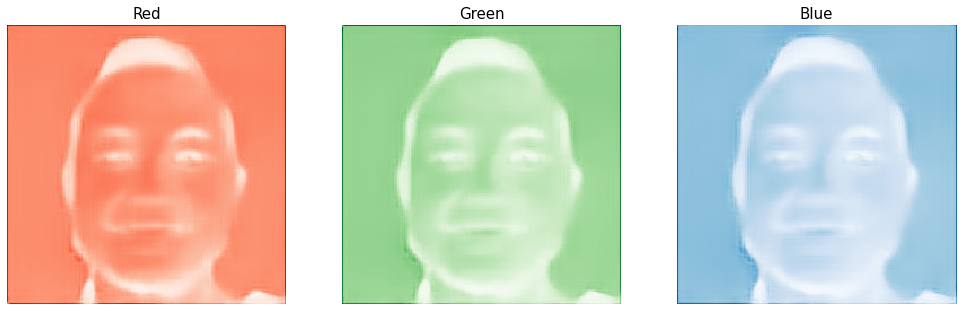

In [21]:
convolved_rgb_sharpen = convolver_rgb(prediction, sharpen, 1)


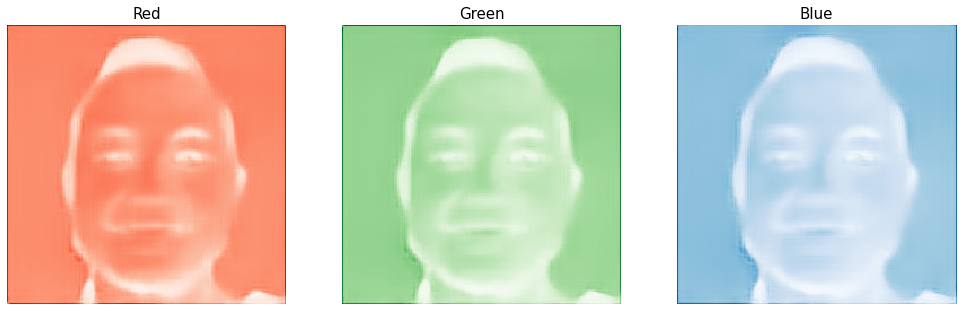

In [22]:
convolved_rgb_sharpen = convolver_rgb(prediction, sharpen, 1)


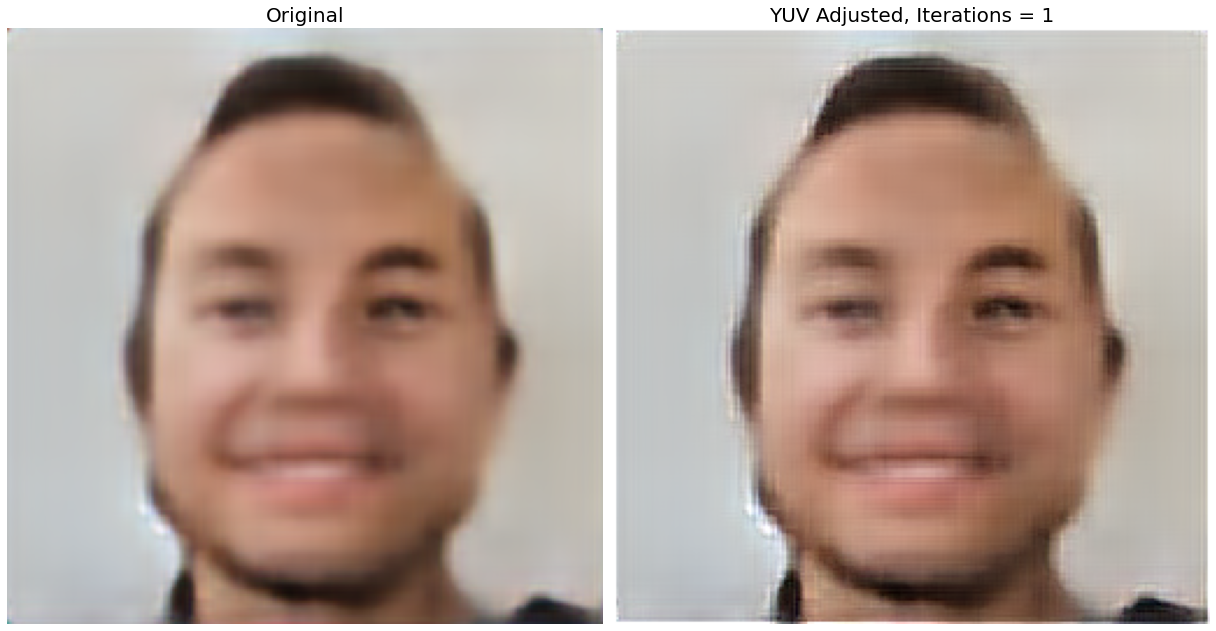

In [23]:
def convolver_rgb(image, kernel, iterations = 1):
    img_yuv = rgb2yuv(image)   
    img_yuv[:,:,0] = multi_convolver(img_yuv[:,:,0], kernel, 
                                     iterations)
    final_image = yuv2rgb(img_yuv)
                               
    fig, ax = plt.subplots(1,2, figsize = (17,10))
    
    ax[0].imshow(image)
    ax[0].set_title(f'Original', fontsize = 20)
    
    ax[1].imshow(final_image);
    ax[1].set_title(f'YUV Adjusted, Iterations = {iterations}', 
                    fontsize = 20)
    
    [axi.set_axis_off() for axi in ax.ravel()]
    
    fig.tight_layout()
    
    return final_image
final_image = convolver_rgb(prediction, sharpen, iterations = 1)

# Thanks for your visit